# Predicting Player Activity on a Minecraft Research Server


### Introduction


In this investigation, we will predict the total hours played by players according to the players.csv dataset. In the study led by Frank Wood, players’ actions and profiles were observed on a Minecraft server. One of the research's key challenges is predicting which types of players are likely to generate large amounts of gameplay data. This information would allow them to target recruitment more effectively and plan the necessary computing resources to operate the server. For the purpose of this report, we will see if the data describing each player in players.csv, which includes 196 observations and 7 variables: (experience, subscription, “hashedEmail,” played hours, name, gender, and age), can predict the total hours played by a player. Below is a summary of the players.csv data set:

|Variable Name | Type | Description |
|---|---|---|
| experience | character | Tells us the player's experience level: beginner, regular, amateur, veteran, or pro  |
|subscribe | logical | Whether the player subscribed to the newsletter (TRUE = subscribed, FALSE = not subscribed), there are 52 players not subscribed and 144 subscribed  |
|hashedemail | character | Encrypted player email identifier  |
|played_hours | numeric | Total number of hours the player has spent playing|
|name | character | Player's name|
| gender | character | Gives the player's gender|
| age | numeric | Player's age in years|


To begin exploring our question, we wanted to choose predictor variables based on those we inferred would have the most impact on predicting the total hours played. We selected gender and age, because they are variables that capture basic demographic differences that may affect gaming habits, including how much they play and how long they stay active on the server. These variables are commonly used in behavioural data analysis, and they offer a straightforward starting point for understanding what types of players may spend more time on the server. By grouping age into categories and treating gender as a factor, we ensured the predictors fit naturally into a regression model. This narrowed down our question to: ***Can the variables of gender and age group be used to predict the total hours played by a player?***
Because we wanted to predict a numerical value, hours_played, using different types of variables, we decided to use linear regression as our method of prediction. This is also helpful because the data set is relatively small, and linear regression offers a clear and transparent way to understand how each of these variables will contribute to predicting hours played.

### Method & Results

##### Loading and Cleaning Data

In [1]:
# Loading Appropriate Packages 
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Loading and Reading Data
players<- read_csv("data/players.csv")

# Wrangling and cleaning data
# 1. Converting categorical variables to factors

clean_players<- players|>
drop_na()|>
select(played_hours, gender, Age,)|>
mutate(gender=as_factor(gender))|>
filter(played_hours > 0) |>
    mutate(age_group = cut(Age, breaks = c(5, 10, 15, 20, 25, 30, 35, 40, 45, 50, Inf), labels = c("5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50+")))


# Relevant summary of the Dataset
summary(clean_players)



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


  played_hours                  gender        Age         age_group 
 Min.   :  0.10   Male             :75   Min.   : 9.0   15-19  :51  
 1st Qu.:  0.10   Female           :21   1st Qu.:17.0   20-24  :35  
 Median :  0.50   Non-binary       : 6   Median :20.0   10-14  : 6  
 Mean   : 10.51   Prefer not to say: 5   Mean   :21.3   25-29  : 6  
 3rd Qu.:  1.80   Agender          : 1   3rd Qu.:23.0   5-9    : 2  
 Max.   :223.10   Two-Spirited     : 1   Max.   :58.0   30-34  : 2  
                                                        (Other): 7  

#### Visualization for Exploratory Dataset

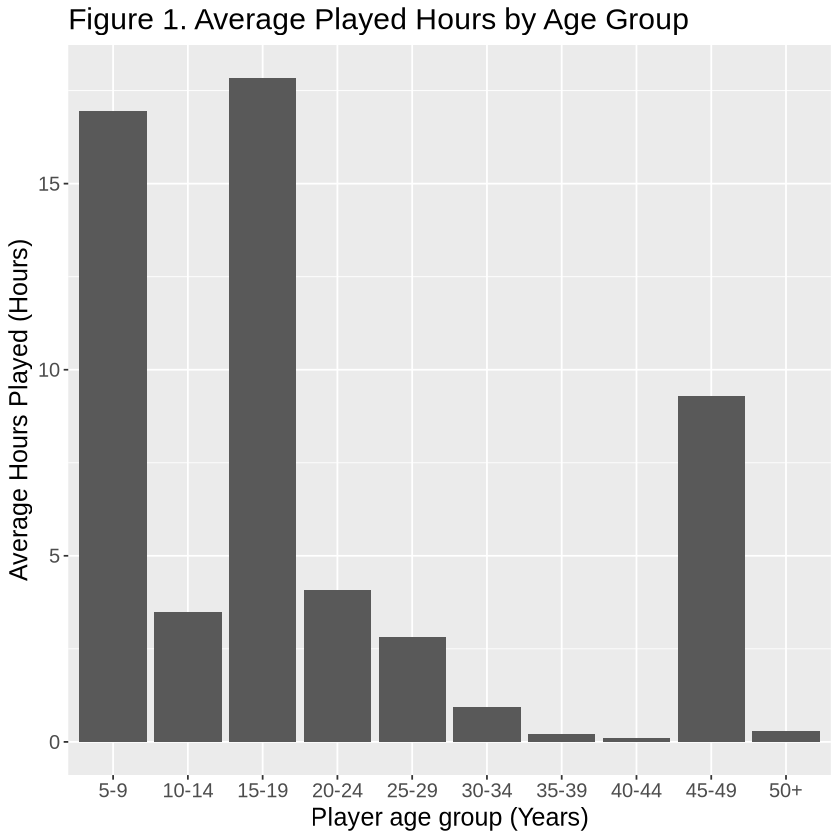

In [3]:
# Figure 1. Average Played Hours by Age Group

avg_hrs_played_by_age_group<- clean_players|>
group_by(age_group)|>
summarise(avg_played_hrs = mean(played_hours))

figure_1<- ggplot(avg_hrs_played_by_age_group, aes(x = age_group, y = avg_played_hrs))+
geom_bar(stat="identity")+
labs( title = "Figure 1. Average Played Hours by Age Group",
     x = "Player age group (Years)",
     y= "Average Hours Played (Hours)")+
        theme(text = element_text(size = 15))



figure_1


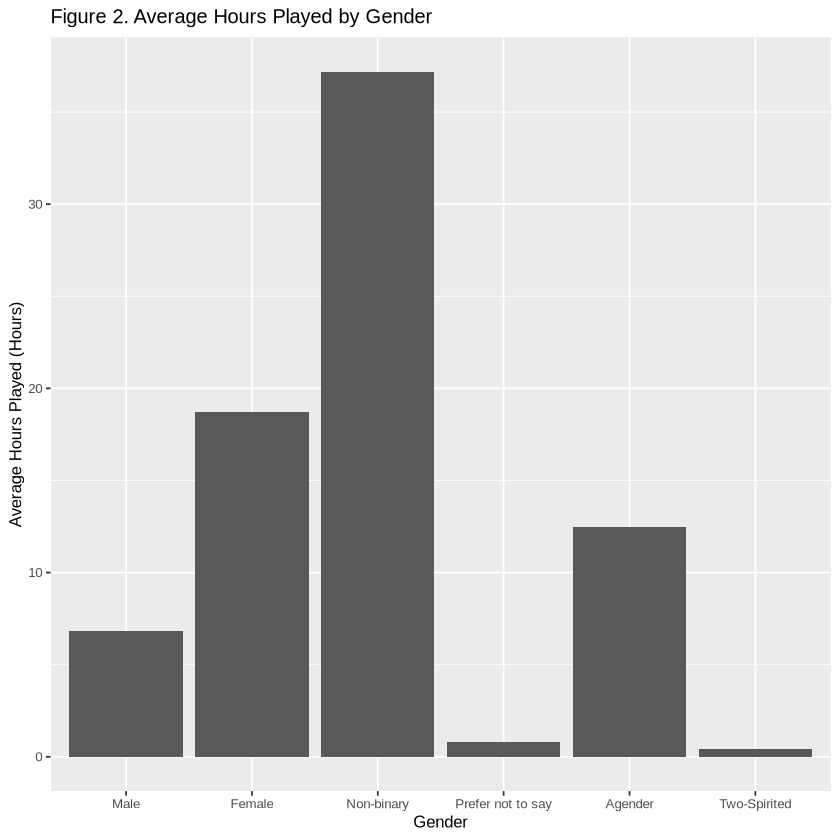

In [4]:
#Figure 2. Average Hours Played by Gender
avg_hours_gender <- clean_players |>
  group_by(gender) |>
  summarise(avg_hours = mean(played_hours))

figure_2 <- ggplot(avg_hours_gender,
                   aes(x = gender, y = avg_hours)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Figure 2. Average Hours Played by Gender",
    x = "Gender",
    y = "Average Hours Played (Hours)"
  ) +
  theme(text = element_text(size = 10))

figure_2


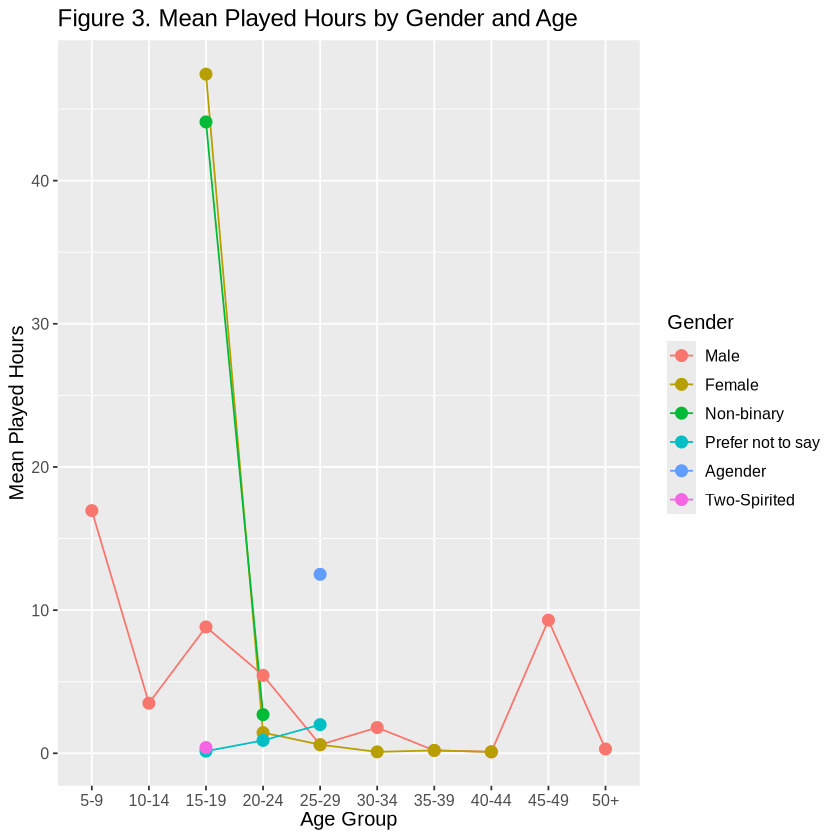

In [5]:
#Figure 3. Line plot of Average Played Hours by Gender and Age
mean_played_hours_by_gender_and_age<- clean_players|>
group_by(age_group, gender)|>
summarise(mean_played_hours = mean(played_hours), .groups="drop")

line_plot<- mean_played_hours_by_gender_and_age|>
ggplot(aes(x=age_group, y= mean_played_hours, group = gender, color = gender))+
geom_line()+
geom_point(size=3)+
labs(x= "Age Group", y = " Mean Played Hours ", color = "Gender")+
theme(text= element_text(size=12))+
ggtitle("Figure 3. Mean Played Hours by Gender and Age")
line_plot



### Data Analysis with Linear Regression
To answer our question of whether player characteristics can predict total hours played, we used a linear regression model with age and gender as predictors. Linear regression is appropriate because the outcome (played_hours) is numeric, and the goal is to estimate how the average value of the outcome changes with each predictor.

In [55]:
library(tidymodels)
set.seed(123)

# Train/test split
data_split <- initial_split(clean_players, prop = 0.75)
train_data <- training(data_split)
test_data  <- testing(data_split)

We split the cleaned data set into a 75% training set and a 25% test set using the initial_split function. The model was trained exclusively on the training data to avoid overfitting, and performance was evaluated using the test data.

In [8]:
# Recipe (preprocessing)
player_recipe <- recipe(played_hours ~ Age + gender, data = train_data) |>
  step_dummy(all_nominal_predictors()) |>
  step_normalize(all_numeric_predictors(), -all_outcomes())

# Defining model
lm_model <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

# Workflow
lm_workflow <- workflow() |>
  add_model(lm_model) |>
  add_recipe(player_recipe)

# Fitting model
lm_fit <- fit(lm_workflow, data = train_data)

We used the linear_reg function with the lm engine to fit the model. Prior to fitting, we applied a recipe that created dummy variables for gender and normalized numeric predictors. This allowed the model to compare categories properly and ensured all variables were on a similar scale.

In [9]:
# Calculating RMSE on Training set 
rmse_results <- lm_fit |>
    predict(train_data) |>
    bind_cols(train_data) |>
    metrics(truth = played_hours, estimate = .pred)
rmse_results

#Calculating RMSE on Training set 
rmse<-lm_fit|>
predict(train_data)|>
bind_cols(players_training)|>
metrics(truth=played_hours, estimate=pred)|>
filter(.metric="rmse")|>
select(.estimate)|>
pull()

# Test performance
lm_test_results <- lm_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = played_hours, estimate = .pred)
lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,29.6264125
rsq,standard,0.1318751
mae,standard,12.3692946


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,52.168618015
rsq,standard,0.000425236
mae,standard,21.705901583


We evaluated model accuracy using Root Mean Squared Error on both the training and test sets. RMSE measures the average distance between predicted and actual played_hours. Larger RMSE values indicate that predictions tend to be farther from the true values.
- Training RMSE: 29.63
- Test RMSPE: 52.17

These values suggest that the model has limited predictive ability. The test error is substantially higher than the training error, meaning the model does not generalize well to unseen data.

### Discussion
The goal of this investigation was to determine whether a player’s age and gender could be used to predict the total number of hours they played on a Minecraft research server. After cleaning and exploring the dataset, we built a linear regression model using these two predictors. The results showed that the model performed poorly, with a RMSE of ~ 29.6 hours and a higher RMSPE of ~ 52.2 hours. These error values indicate that the model’s predictions were often far from the true number of hours played. Additionally, none of the predictors showed strong or consistent relationships with the outcome.

The results were largely expected. Before running the model, we did not anticipate that age or gender would be strong predictors of gaming activity based on our exploratory visualizations. Our EDA plots showed only weak and inconsistent trends between played hours and both age group and gender. The bar plot of average played hours across age groups showed no clear increasing or decreasing trend, the bar plot comparing genders showed irregularity among groups, and the line plot showed no stable or predictable relationship between demographics and playtime. These observations suggested that neither predictor was strongly correlated with total hours played. Additionally, total hours played is a highly individual behaviour influenced by many complex factors that are not present in the initial dataset to begin with, such as motivation to play, how much free time a player has, or personal interest. Because our predictors captured only basic demographics, it was reasonable to expect that the model would not be able to explain much of the variation in played hours. The large differences in playtime between users also made it difficult for a simple model to accurately estimate individual values.

The findings suggest that demographic information alone is not sufficient for understanding or predicting player engagement on this server. For researchers or game designers aiming to target recruitment or allocate computing resources more efficiently, this means that more meaningful behavioural data is likely needed. Variables such as login frequency, time of day, or in-game actions would probably yield better insights than demographics alone. Our model’s weak performance highlights the importance of collecting richer, activity-based predictors when trying to estimate player behaviour.

This analysis raises several questions that could guide future work. One direction would be to investigate which behaviour based variables correlate most strongly with played hours. Another question is whether different types of players (e.g., beginner vs. experienced) follow different patterns that would require separate models. Additionally, exploring non-linear models or models that incorporate more detailed timebased features might lead to more accurate predictions. Expanding the dataset to include more diverse or detailed variables could help build a stronger understanding of what drives players to be more highly active on the server.

**References**

Wood, Frank, and the Department of Computer Science, University of British Columbia. Minecraft Research Server Project: Studying Player Behaviour in Virtual Environments. University of British Columbia, n.d. Web. https://www.cs.ubc.ca

Timbers, T., Campbell, T., Lee, M. Data Science: A First Introduction. CRC press, 2024. 